<a href="https://colab.research.google.com/github/Tsyhankova/thesis/blob/main/TRANSFORMER_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TRANSFORMER**

Modele transformatorów opierają się na mechanizmach uwagi do obliczania reprezentacji par „wypowiedź - odpowiedź”, co pozwala na większą równoległość. Główna różnica między modelami Transformer a tradycyjnymi modelami sekwencyjnymi polega na tym, że transformator jest w stanie spojrzeć na całą sekwencję jednocześnie.

### Przegląd Architektury Modelu Transformatora

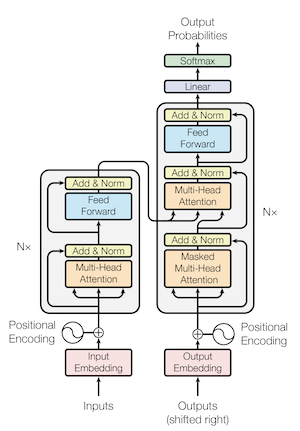

Architektura modelu transformatora od [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

Model transformatora jest zgodny z architekturą kodera-dekodera, jak pokazano powyżej.

# Import zależności i konfiguracja parametrów

In [ ]:
import re
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

# config params
VOCAB_SIZE = 4488
OUTPUT_SEQUENCE_LENGTH = 20
MAX_SAMPLES = 35000
BUFFER_SIZE = 1024 #1024
BATCH_SIZE = 1024 #1024 
EPOCHS = 100
EMBED_DIM = 300 #256
LATENT_DIM = 512
NUM_HEADS = 8
START_TOKEN = 'BOS'
STOP_TOKEN = 'EOS'

# Inicjalizacja TPU/GPU

Aby poprawić naukę w Colab, wybierzemy  akcelerator TPU / GPU.

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


### Pobieranie Danych

In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

lines_filename = os.path.join(path_to_dataset, 'movie_lines.txt')
conversations_filename = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

9916637/9916637 [==============================] - 0s 0us/step


## Wstępne przetwarzanie danych

Dane są prezentowane w formie rozmowy należącej do różnych gatunków filmowych. Wyodrębniłam wszystkie ciągi dialogowe za pomocą plików movie_conversations i movie_lines. Wykorzystałam każdą rozmowę jako pytanie, po którym następuje odpowiedź.

In [ ]:
#read lines into list
lines = open(lines_filename, errors='ignore').read().split('\n')
#read conversations into list
conversations = open(conversations_filename,encoding=('utf-8'), errors='ignore').read().split('\n')

print(lines[:3])
print(conversations[:3])

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!', 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!', 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.']
["u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']", "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']", "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']"]


In [ ]:
def preprocess():
    #read lines into list
    lines = open(lines_filename, errors='ignore').read().split('\n')
    #read conversations into list
    conversations = open(conversations_filename,encoding=('utf-8'), errors='ignore').read().split('\n')

    movie_lines = {}
    for line in lines:
        line = line.split(' +++$+++ ')
        movie_lines[line[0]] = line[-1]
        
    conversations = [conv.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(',',"").split() for conv in conversations]
    
    questions = []
    answers = []
    
    for conv in conversations:
        for i in range(len(conv)-1):
            questions.append(movie_lines[conv[i]])
            answers.append(movie_lines[conv[i+1]])
            
    return questions, answers

In [ ]:
questions, answers = preprocess()
print(questions[:3])
print(answers[:3])

['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.', "Well, I thought we'd start with pronunciation, if that's okay with you.", 'Not the hacking and gagging and spitting part.  Please.']
["Well, I thought we'd start with pronunciation, if that's okay with you.", 'Not the hacking and gagging and spitting part.  Please.', "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?"]


## Konwertujemy dane na małe litery, przycinamy i usuwamy wszystkie znaki nieliterowe

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", r"i am", text)
    text = re.sub(r"\'s", r" is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"thats", r"that is", text)
    text = re.sub(r"\'em", r"them", text)
    text = re.sub(r"gonna", r"going to", text)
    text = re.sub(r"btw", r"by the way", text)
    text = re.sub(r'[^\w\s]', r'', text)
    text = re.sub(r"[!.?,*/|'\_^\+:;<>=#$-`~]", r"", text) 
    text.strip()
    return text

In [ ]:
questions = [clean_text(q) for q in questions]
answers = [clean_text(a) for a in answers]

pairs = (list(zip(questions, answers)))#[:MAX_SAMPLES]

In [ ]:
print(pairs[:6])

[('can we make this quick  roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad  again', 'well i thought we would start with pronunciation if that is okay with you'), ('well i thought we would start with pronunciation if that is okay with you', 'not the hacking and gagging and spitting part  please'), ('not the hacking and gagging and spitting part  please', 'okay then how about we try out some french cuisine  saturday  night'), ('you are asking me out  that is so cute what is your name again', 'forget it'), ('no no it is my fault  we did not have a proper introduction ', 'cameron'), ('cameron', 'the thing is cameron  i am at the mercy of a particularly hideous breed of loser  my sister  i ca not date until she does')]


In [ ]:
max_q_length = 14 #the maximum length of the question so that the collab does not fall
max_a_length = 12 #the maximum length of the answers so that the collab does not fall, with BOS, EOS, will be 14

questions = [pair[0] for pair in pairs
             if len(pair[0].split())<=max_q_length 
             and len(pair[1].split())<=max_a_length 
             and len(pair[0].split())>=1 
             and len(pair[1].split())>=1]
answers = [pair[1] for pair in pairs 
           if len(pair[0].split())<=max_q_length 
           and len(pair[1].split()) <=max_a_length 
           and len(pair[0].split())>=1 
           and len(pair[1].split())>=1]          

In [ ]:
print(questions[:3])
print(answers[:3])

['well i thought we would start with pronunciation if that is okay with you', 'not the hacking and gagging and spitting part  please', 'you are asking me out  that is so cute what is your name again']
['not the hacking and gagging and spitting part  please', 'okay then how about we try out some french cuisine  saturday  night', 'forget it']


In [ ]:
answers = ["BOS "+answer for answer in answers]
answers = [answer+" EOS" for answer in answers]

In [ ]:
questions[:5]

['well i thought we would start with pronunciation if that is okay with you',
 'not the hacking and gagging and spitting part  please',
 'you are asking me out  that is so cute what is your name again',
 'no no it is my fault  we did not have a proper introduction ',
 'gosh if only we could find kat a boyfriend']

In [ ]:
answers[:5]

['BOS not the hacking and gagging and spitting part  please EOS',
 'BOS okay then how about we try out some french cuisine  saturday  night EOS',
 'BOS forget it EOS',
 'BOS cameron EOS',
 'BOS let me see what i can do EOS']

In [ ]:
answers = answers[:35000]
questions = questions[:35000]
len(answers)

35000

In [ ]:
len(questions)

35000

In [ ]:
def get_vectorizer(questions, answers):
    input_vectorizer = layers.TextVectorization(
        VOCAB_SIZE,
        output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
        standardize=None
    )
    target_vectorizer = layers.TextVectorization(
        VOCAB_SIZE,
        output_sequence_length=OUTPUT_SEQUENCE_LENGTH + 1,
        standardize=None
    )
    input_vectorizer.adapt(list(questions))
    target_vectorizer.adapt(list(answers))
    return input_vectorizer, target_vectorizer

with tf.device('/GPU:0'):
  input_vectorizer, target_vectorizer = get_vectorizer(questions, answers)

In [ ]:
type(target_vectorizer)

keras.layers.preprocessing.text_vectorization.TextVectorization

In [ ]:
target_vectorizer(["if"])[:, :-1]

<tf.Tensor: shape=(1, 20), dtype=int64, numpy=
array([[74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])>

In [ ]:
test_size = int(len(questions)*0.2) #7000
val_size  = int((len(questions)-test_size)*0.2) #5600

encoder_input_test, decoder_input_test = questions[:test_size], answers[:test_size]
encoder_input_val, decoder_input_val = questions[test_size: test_size + val_size], answers[test_size: test_size + val_size]
encoder_input_train, decoder_input_train = questions[ test_size +val_size:], answers[ test_size+val_size:]

In [ ]:
len(encoder_input_train)

22400

In [ ]:
len(encoder_input_val)

5600

In [ ]:
len(encoder_input_test)

7000

## Utworzymy Zestaw Danych

In [ ]:
def create_dataset(questions, answers):
    def vectorize_text(questions, answers):
        inputs, outputs = input_vectorizer(questions), target_vectorizer(answers)
        return (
            {"encoder_inputs": inputs, "decoder_inputs": outputs[:, :-1]},
            {"outputs": outputs[:, 1:]}
        )

    dataset = tf.data.Dataset.from_tensor_slices((list(questions), list(answers)))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(vectorize_text)
    return dataset.shuffle(BUFFER_SIZE).prefetch(16).cache()

train_ds = create_dataset(encoder_input_train, decoder_input_train)
valid_ds = create_dataset(encoder_input_val, decoder_input_val)
#test_ds = create_dataset(encoder_input_test, decoder_input_test)

In [ ]:
len(input_vectorizer(questions))

35000

In [ ]:
train_ds

<CacheDataset element_spec=({'encoder_inputs': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None), 'decoder_inputs': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None)}, {'outputs': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None)})>

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')

inputs["encoder_inputs"].shape: (1024, 20)
inputs["decoder_inputs"].shape: (1024, 20)


# **Budowanie modelu**

Transformer (transformator) użyty w tym badaniu jest zbudowany bezpośrednio z transformatora opisanego François Chollet w „[English-to-Spanish translation with a sequence-to-sequence Transformer](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)”  ze zmodyfikowanym wyjściem dla chatbota.

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"), 
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    """"
    Example:

    class CustomLayer(keras.layers.Layer):
        def __init__(self, arg1, arg2):
            super().__init__()
            self.arg1 = arg1
            self.arg2 = arg2

        def get_config(self):
            config = super().get_config()
            config.update({
                "arg1": self.arg1,
                "arg2": self.arg2,
            })
            return config
        """
    #embed_dim, dense_dim, num_heads
    def get_config(self):
            config = super().get_config()
            config.update({
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            })
            return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
            
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super(PositionalEmbedding, self).__init__()
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        ''''
        Example:

        class CustomLayer(keras.layers.Layer):
            def __init__(self, arg1, arg2):
                super().__init__()
                self.arg1 = arg1
                self.arg2 = arg2

            def get_config(self):
                config = super().get_config()
                config.update({
                    "arg1": self.arg1,
                    "arg2": self.arg2,
                })
                return config
        '''

    #'sequence_length', 'vocab_size', 'embed_dim'
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(length)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads):
        super(TransformerDecoder, self).__init__()
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"), 
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    """"
    class CustomLayer(keras.layers.Layer):
        def __init__(self, arg1, arg2):
            super().__init__()
            self.arg1 = arg1
            self.arg2 = arg2

        def get_config(self):
            config = super().get_config()
            config.update({
                "arg1": self.arg1,
                "arg2": self.arg2,
            })
            return config
        """
    #embed_dim, latent_dim, num_heads
    def get_config(self):
            config = super().get_config()
            config.update({
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            })
            return config

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1, value=encoder_outputs,key=encoder_outputs,
            attention_mask=padding_mask
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        #print(i, j)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [ ]:
def create_model() -> keras.Model:
    # encoder
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    encoder_augmented_inputs = PositionalEmbedding(OUTPUT_SEQUENCE_LENGTH, VOCAB_SIZE, EMBED_DIM)(encoder_inputs)
    encoder_outputs = TransformerEncoder(EMBED_DIM, LATENT_DIM, NUM_HEADS)(encoder_augmented_inputs)

    # decoder
    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")
    decoder_augmented_inputs = PositionalEmbedding(OUTPUT_SEQUENCE_LENGTH, VOCAB_SIZE, EMBED_DIM)(decoder_inputs)
    decoder_outputs = TransformerDecoder(EMBED_DIM, LATENT_DIM, NUM_HEADS)(decoder_augmented_inputs, encoded_seq_inputs)
    decoder_outputs = layers.Dropout(0.7)(decoder_outputs)
    decoder_outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(decoder_outputs)

    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name='outputs')
    decoder_outputs = decoder([decoder_inputs, encoder_outputs])

    model = keras.Model(
        [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
    )

    model.compile(
        "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model

model = create_model()

In [ ]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 300)   1352400     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 300)   3196712     ['positional_embedding[

In [ ]:
from keras.utils import plot_model

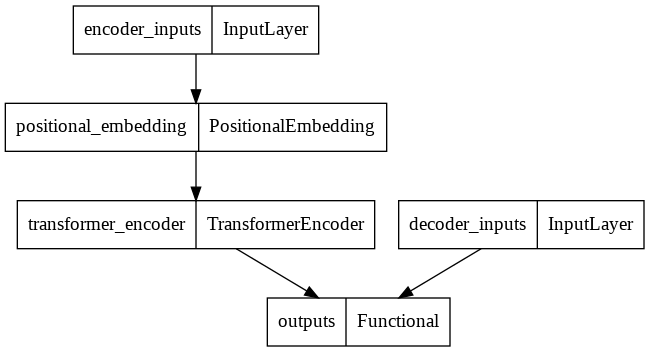

In [ ]:
plot_model(model)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = "/content/gdrive/MyDrive/models/transformer_chatbot.h5"
path_weight = "/content/gdrive/MyDrive/models/transformer_chatbot_weights.h5"

In [ ]:
import time

checkpoint_filepath = '/content/gdrive/MyDrive/models/Transformer'+ time.strftime("%d%m%y%H%M")+'.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                               filepath=checkpoint_filepath, 
                                                               save_weights_only=True, 
                                                               monitor='val_loss', 
                                                               mode='min', 
                                                               save_best_only=True
                                                               )
        
model_scheduler_loss_val = tf.keras.callbacks.ReduceLROnPlateau(
                                                                monitor='val_loss', 
                                                                factor=tf.math.exp(-0.1), 
                                                                patience=3, 
                                                                min_lr=0.00001, 
                                                                cooldown=20, 
                                                                verbose=1
                                                                )

In [ ]:
with tf.device('/GPU:0'):
  #model.load_weights("/content/gdrive/MyDrive/models/Transformer2111220852.h5")
  history = model.fit(train_ds,  
                      epochs = 8, 
                      callbacks = [
                                  model_scheduler_loss_val, 
                                  model_checkpoint_callback], 
                      validation_data = valid_ds) 

Epoch 1/8
22/22 [==============================] - 18s 708ms/step - loss: 2.1223 - accuracy: 0.2264 - val_loss: 1.7503 - val_accuracy: 0.2759 - lr: 0.0010
Epoch 2/8
22/22 [==============================] - 16s 750ms/step - loss: 1.7163 - accuracy: 0.2852 - val_loss: 1.6163 - val_accuracy: 0.3136 - lr: 0.0010
Epoch 3/8
22/22 [==============================] - 17s 767ms/step - loss: 1.5885 - accuracy: 0.3232 - val_loss: 1.5247 - val_accuracy: 0.3419 - lr: 0.0010
Epoch 4/8
22/22 [==============================] - 17s 757ms/step - loss: 1.5037 - accuracy: 0.3404 - val_loss: 1.4865 - val_accuracy: 0.3505 - lr: 0.0010
Epoch 5/8
22/22 [==============================] - 16s 747ms/step - loss: 1.4512 - accuracy: 0.3493 - val_loss: 1.4665 - val_accuracy: 0.3526 - lr: 0.0010
Epoch 6/8
22/22 [==============================] - 16s 732ms/step - loss: 1.4156 - accuracy: 0.3557 - val_loss: 1.4566 - val_accuracy: 0.3529 - lr: 0.0010
Epoch 7/8
22/22 [==============================] - 15s 705ms/step - lo

In [ ]:
model.save("/content/gdrive/MyDrive/models/transformer_chatbot.h5")
model.save_weights("/content/gdrive/MyDrive/models/transformer_chatbot_weights.h5")

In [ ]:
import matplotlib.pyplot as plt

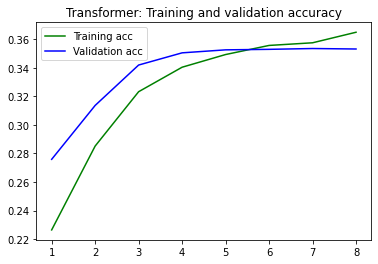

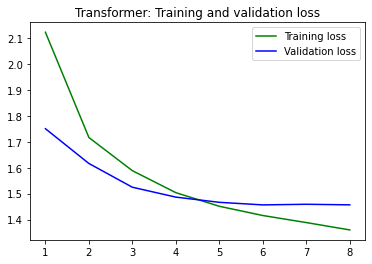

In [ ]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, 9)

plt.title('Transformer: Training and validation accuracy')
plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Transformer: Training and validation loss')
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
test_ds = create_dataset(encoder_input_test, decoder_input_test)
model.evaluate(test_ds)

7/7 [==============================] - 2s 242ms/step - loss: 1.4860 - accuracy: 0.3499


[1.4859603643417358, 0.34986400604248047]

In [ ]:
model.load_weights("/content/gdrive/MyDrive/models/transformer_chatbot_weights.h5")

In [ ]:
vocab = target_vectorizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))

def decode_sequence(input_sentence):
    tokenized_input_sentence = input_vectorizer([input_sentence])
    decoded_sentence = START_TOKEN
    for i in range(OUTPUT_SEQUENCE_LENGTH):
        tokenized_target_sentence = target_vectorizer([decoded_sentence])[:, :-1]
        predictions = model([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        #print(sampled_token)
        decoded_sentence += ' ' + sampled_token

        if sampled_token == STOP_TOKEN:
            break
    return decoded_sentence

def response(input_text):
    translated = decode_sequence(input_text)
    print('Output: ', translated)
    return translated

In [ ]:
sentence = "What do you think about it?"
for _ in range(5):
    print(f"Input: {sentence}")
    sentence = response(sentence)

Input: What do you think about it?
Output:  BOS what are my orders EOS
Input: BOS what are my orders EOS
Output:  BOS how many minutes between you and burn the [UNK] and thursdays EOS
Input: BOS how many minutes between you and burn the [UNK] and thursdays EOS
Output:  BOS what do you do with him to tell me EOS
Input: BOS what do you do with him to tell me EOS
Output:  BOS you know god you do [UNK] me EOS
Input: BOS you know god you do [UNK] me EOS
Output:  BOS where are you EOS


In [ ]:
#online consultant of an electronics store
sentence = ''
while 1:
    print('-'*50)
    sentence = input('Input:')
    if(sentence=='quit'):
        break
        
    sentence = response(sentence)

--------------------------------------------------
Input:Hello
Output:  BOS [UNK] EOS
--------------------------------------------------
Input:Do you have this type of motherboard in the warehouse?
Output:  BOS shit you wanna start EOS
--------------------------------------------------
Input:How fast it can be delivered to the my address?
Output:  BOS congratulations EOS
--------------------------------------------------
Input:If this processor compare to the lga1155 socket?
Output:  BOS that is right frank EOS
--------------------------------------------------
Input:What can you propose to buy to make laptop works faster?
Output:  BOS what the fuck is through the walls EOS
--------------------------------------------------
Input:Do you have a offline shop to have opportunity to test it?
Output:  BOS never EOS
--------------------------------------------------
Input:Do you give a guarantee for that hard disk?
Output:  BOS shut up EOS
--------------------------------------------------
I

In [ ]:
#any person
sentence = ''
while 1:
    print('-'*50)
    sentence = input('Input:')
    if(sentence=='quit'):
        break
        
    sentence = response(sentence)

--------------------------------------------------
Input:Hi! How are you?
Output:  BOS i will be [UNK] in my head EOS
--------------------------------------------------
Input:Where are you going?
Output:  BOS i am in my bedroom EOS
--------------------------------------------------
Input:Where are you living?
Output:  BOS i am in my bedroom EOS
--------------------------------------------------
Input:Do you like the weather?
Output:  BOS great [UNK] has whatever they want EOS
--------------------------------------------------
Input:Do you like pizza?
Output:  BOS great on EOS
--------------------------------------------------
Input:What do you want to do?
Output:  BOS no i want to tell you something me to be too EOS
--------------------------------------------------
Input:What about?
Output:  BOS what EOS
--------------------------------------------------
Input:You just say. I do not know
Output:  BOS we ca not take [UNK] to the funeral EOS
---------------------------------------------

# **Ocena efektywności**

# **Perplexity**

In [ ]:
model.load_weights("/content/gdrive/MyDrive/models/Transformer2111221009.h5")

In [ ]:
test_ds = create_dataset(encoder_input_test, decoder_input_test)

In [ ]:
inputs, outputs = input_vectorizer(encoder_input_test), target_vectorizer(decoder_input_test)
x_test = [inputs,outputs[:, :-1]]

In [ ]:
y_test = target_vectorizer(decoder_input_test)
y_test = y_test[:, 1:]

In [ ]:
import math

# make predictions from the test data
ypred=model.predict(x_test)

# reshape back into a single long sequence
nseq=ypred.shape[0]
seqlen=ypred.shape[1]
ypred=np.reshape(ypred,(nseq*seqlen,ypred.shape[2]));

# reshape the original test data back to a single sequence
ytest_seq=np.reshape(y_test,(nseq*seqlen,1))

# collect all the probabilities assigned to the actual words 
probs=[]
for i in range(ytest_seq.shape[0]):
  probs.append(ypred[i,int(ytest_seq[i])])

# get the mean probability, entropy and perplexity
meanprob=np.mean(probs)
entropy=np.mean(-np.log(probs))
print("mean probability",meanprob,"entropy",entropy,"perplexity",math.exp(entropy))

219/219 [==============================] - 1s 5ms/step
mean probability 0.11752387 entropy 4.3917384 perplexity 80.7807273972167


# **F1**

In [ ]:
test_ds = create_dataset(encoder_input_test, decoder_input_test)

In [ ]:
vocab = target_vectorizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))

def decode_sequence(input_sentence):
    tokenized_input_sentence = input_vectorizer([input_sentence])
    decoded_sentence = START_TOKEN
    for i in range(OUTPUT_SEQUENCE_LENGTH):
        tokenized_target_sentence = target_vectorizer([decoded_sentence])[:, :-1]
        predictions = model([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        #print(sampled_token)
        decoded_sentence += ' ' + sampled_token

        if sampled_token == STOP_TOKEN:
            break
    return decoded_sentence

def response(input_text):
    translated = decode_sequence(input_text)
    #print('Output: ', translated)
    return translated #pred


In [ ]:
def f1_score(input_test, reply):

  # F1 = 2 * (precision * recall) / (precision + recall)
  # precision =  matched words /  pred words
  # recall =  matches words /  reply words
  
  pred = response(input_test)

  reply = reply.split(' ')
  pred = pred.split(' ')

  matched_words = len([w for w in set(pred) if w in reply])
    
  if matched_words == 0:
    return 0
    
  precision = matched_words / len(pred)
  recall = matched_words / len(reply)

  return 2 * ( (precision * recall) / (precision + recall) )

In [ ]:
def f1():
  f1 = 0
  pairs = (list(zip(encoder_input_test, decoder_input_test)))
  for p, r in pairs:
    input_test = p
    reply = r
    f1 += f1_score(input_test, reply)
  return f1 / len(encoder_input_test)

In [ ]:
f1 = f1()
print(f1)

0.3679189852571627
